# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils import *

import numpy as np

np.set_printoptions(precision = 4)

data_base_dir = "./data"
out_base_dir = "./output"
example_base_dir = "./examples"

## Computing camera calibration using chessboard images

In [2]:
ret, cameraMatrix, distCoeffs, rvecs, tvecs = get_camera_calibration_matrix(6, 9,
                                                                            data_base_dir + "/camera_calibration",
                                                                            out_base_dir + "/output_camera_calibration")

Calibrating Image:  calibration10
Calibrating Image:  calibration7
Calibrating Image:  calibration3
Calibrating Image:  calibration4
Calibrating Image:  calibration1
Calibrating Image:  calibration16
Calibrating Image:  calibration17
Calibrating Image:  calibration13
Calibrating Image:  calibration19
Calibrating Image:  calibration14
Calibrating Image:  calibration9
Calibrating Image:  calibration15
Calibrating Image:  calibration12
Calibrating Image:  calibration5
Calibrating Image:  calibration8
Calibrating Image:  calibration2
Calibrating Image:  calibration20
Calibrating Image:  calibration18
Calibrating Image:  calibration6
Calibrating Image:  calibration11


<Figure size 1368x576 with 0 Axes>

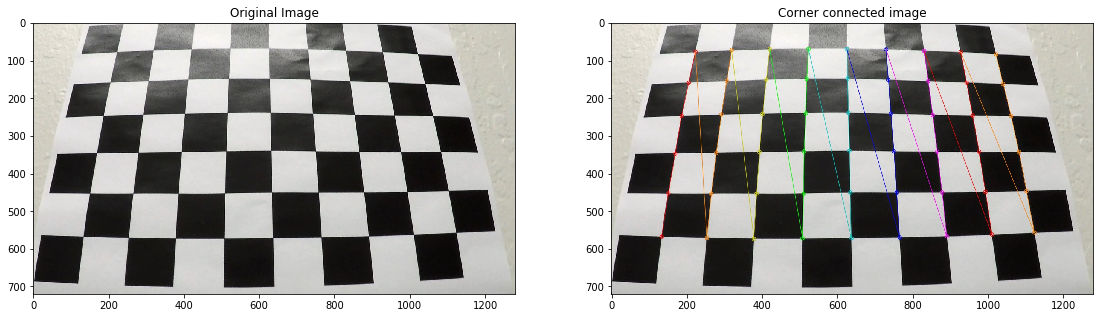

In [17]:
from utils import *

plot_images(data_base_dir + "/camera_calibration/calibration3.jpg",
            out_base_dir + "/output_camera_calibration/calibration3.jpg",
            "Original Image", "Corner connected image", 
            example_base_dir + "/chessboard.jpg")

## Undistorting test images

In [18]:
undistort_images(cameraMatrix, distCoeffs,
                 data_base_dir + "/test_images",
                 out_base_dir + "/undistorted_test_images")

Undistorting Image:  test2
Undistorting Image:  straight_lines2
Undistorting Image:  test1
Undistorting Image:  test6
Undistorting Image:  straight_lines1
Undistorting Image:  test3
Undistorting Image:  test4
Undistorting Image:  test5


<Figure size 1368x576 with 0 Axes>

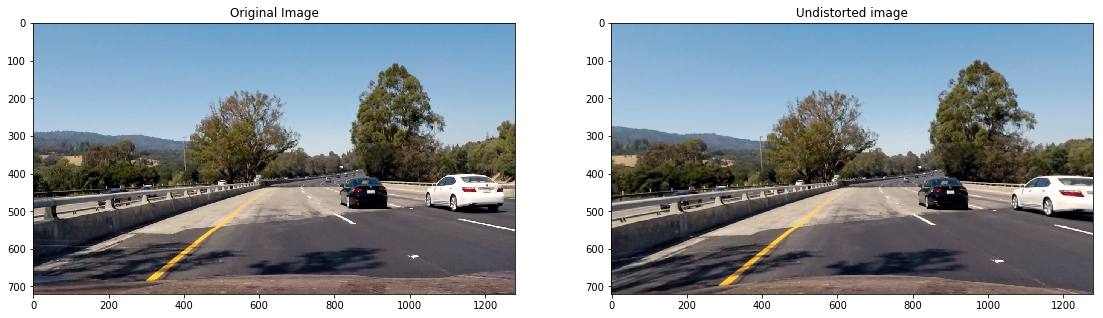

In [19]:
plot_images(data_base_dir + "/test_images/test4.jpg",
            out_base_dir + "/undistorted_test_images/test4.jpg",
            "Original Image", "Undistorted image", 
            example_base_dir + "/undistorted.jpg")

Previously we used canny edge detector to find lane line, canny finds all possibles edges, however lane line are vertically and therefore we can use sobel to find only vertical lines